<h2><font style="font-weight:lighter", color='960018'>Introduction</font></h2>

<font color='#3c3c3c'>
The site launched an A/B test in order to increase income. The excel file contains raw data on the results of the experiment (userid), sample type (variantname) and income brought by the user (revenue).
The task is to analyze the results of the experiment and write your recommendations.
</font>

<h2><font style="font-weight:lighter", color='960018'>Import libraries and data</font></h2>

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

<h4>Description of fields</h4>
<br>
<li>USER_ID - user ID</li>
<li>VARIANT_NAME - sample type</li>
<li>REVENUE - income brought by the user</li>

In [3]:
df = pd.read_csv('AB_Test_Results.csv')

<h2><font style="font-weight:lighter", color='960018'>Exploratory data analysis</font></h2>

In [10]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [9]:
print(f'Shape of DataFrame: {df.shape}')

Shape of DataFrame: (10000, 3)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
USER_ID,10000.0,4981.080200,2890.590115,2.0,2468.75,4962.0,7511.5,10000.00
REVENUE,10000.0,0.099447,2.318529,0.0,0.00,0.0,0.0,196.01


Сhecking for Null

In [13]:
df.isnull().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [20]:
df.USER_ID.nunique()

6324

The dataframe size is 10000 and the number of unique users is 6324, which means that there are users who fell into both versions

In [34]:
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

As the result above shows there are 1541 user_ids are in two groups.

In [35]:
# we need keep the independent of two groups, so we keep thoes user_id in one group only
single_id = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
single_id = single_id[single_id]

#the single users/data
df = df[df['USER_ID'].isin(single_id.index)]

In [40]:
print(f'Shape of the cleared DataFrame: {df.shape}')

Shape of the cleared DataFrame: (6070, 3)


In [56]:
quantity_of_users = df.groupby(['VARIANT_NAME']).agg({'USER_ID': 'count'})
data = quantity_of_users.values.flatten()
mylabels = ['old_version', 'new_version']

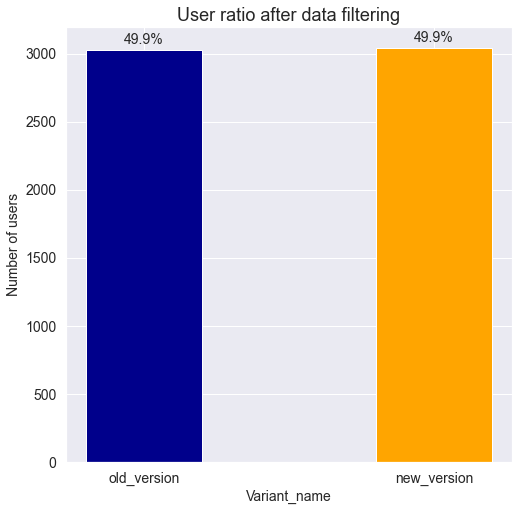

In [57]:
sns.set(rc={'figure.figsize':(8, 8)}) 

x = mylabels
y = quantity_of_users.USER_ID

fig, ax = plt.subplots()

ax.bar(x, y, color=['darkblue', 'orange'], width = 0.4)

for p in ax.patches:
    percentage = '{:.1f}%'.format(data[0]/df.shape[0]*100)
    ax.annotate(percentage,  
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=14)

plt.title('User ratio after data filtering', fontsize=18)

plt.xlabel('Variant_name', fontsize=14)
plt.ylabel('Number of users', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

<h2><font style="font-weight:lighter", color='960018'>Analysis</font></h2>

We don't know what impact the new version might have, so we have to use a two-tailed test.
To do this, set the standard base values and also create 2 hypotheses:

α = 0.05<br>
power = 0.8<br>
<ul>
<li>H0: there is no difference in mean between groups by group and countries</li>
<li>H1: there is difference in mean between groups by group and countries</li>
</ul>



Let's start with statistical tests for all users.

In [59]:
df.groupby('VARIANT_NAME').agg({'USER_ID': 'count', 'REVENUE': 'sum'})

,USER_ID,REVENUE
VARIANT_NAME,,
control,3026,470.56
variant,3044,179.32


In [60]:
ab_info = [[3026, 3044], [471, 179]]

We will conduct several tests to compare the results, first of all I am interested in p_value, which makes it possible to determine the data obtained as a result of chance or regularity

In [65]:
stat, p_value, dof, expected = stats.chi2_contingency(ab_info)
prob = 0.8
alpha = 0.05
print(f' p_value is: {round(p_value, 2)}\n degree of free: {dof}\n stat: {stat}\n')

 p_value is: 0.0
 degree of free: 1
 stat: 119.35247284054691



In [66]:
odd_ratio, p_value = stats.fisher_exact(ab_info)
print(" p_value is: " + str(round(p_value, 2))+'\n')

 p_value is: 0.0



Now let's leave only those users with a REVENUE > 0

In [67]:
df_paying_user = df.loc[df["REVENUE"] > 0]

In [83]:
paying_user = df_paying_user.groupby('VARIANT_NAME').agg({'USER_ID': 'count', 'REVENUE': 'sum'})

In [84]:
paying_user

,USER_ID,REVENUE
VARIANT_NAME,,
control,54,470.56
variant,43,179.32


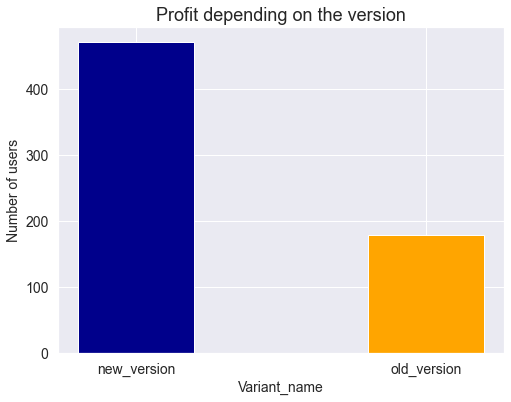

In [96]:
sns.set(rc={'figure.figsize':(8, 6)}) 
x = ['new_version', 'old_version']
y = paying_user.REVENUE

fig, ax = plt.subplots()

ax.bar(x, y, color=['darkblue', 'orange'], width = 0.4)

plt.title('Profit depending on the version', fontsize=18)

plt.xlabel('Variant_name', fontsize=14)
plt.ylabel('Number of users', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [81]:
from scipy.stats import mannwhitneyu

test_stat, pvalue = mannwhitneyu(df_paying_user.loc[(df_paying_user.VARIANT_NAME == 'variant'), 'REVENUE'], 
             df_paying_user.loc[(df_paying_user.VARIANT_NAME == 'control'), 'REVENUE'])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 1030.0000, p-value = 0.3432


<h2><font style="font-weight:lighter", color='960018'>Result</font></h2><br>
The p value = 0.3432 which means we can reject H0, which means the new version has a statistical effect and the difference we saw is not just due to chance. Also from the graph you can see that the new version brought more profit compared to the old one.